In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import numpy as np
import matplotlib.pyplot as plt

import celeri

# Read data and pre-process

In [3]:
COMMAND_FILE_NAME = "../data/command/japan_command_cmi.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-10-30 16:04:08.875 | INFO     | celeri.celeri:get_logger:7577 - Read: ../data/command/japan_command_cmi.json
2024-10-30 16:04:08.876 | INFO     | celeri.celeri:get_logger:7578 - RUN_NAME: 0000000418
2024-10-30 16:04:08.876 | INFO     | celeri.celeri:get_logger:7579 - Write log file: ../runs/0000000418/0000000418.log
2024-10-30 16:04:08.877 | INFO     | celeri.celeri:read_data:451 - Reading data files
2024-10-30 16:04:08.912 | SUCCESS  | celeri.celeri:read_data:455 - Read: ../data/segment/qp_japan_segment.csv
2024-10-30 16:04:08.914 | SUCCESS  | celeri.celeri:read_data:460 - Read: ../data/block/japan_block.csv
2024-10-30 16:04:08.914 | SUCCESS  | celeri.celeri:read_data:467 - Read: ../data/mesh/japan_mesh_parameters_cmi.json

2024-10-30 16:04:08.969 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: ../data/mesh/nankai.msh

2024-10-30 16:04:08.975 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: ../data/mesh/japan.msh

2024-10-30 16:04:08.986 | SUCCESS  | celeri.celeri:read_mesh:446 

# Generate all operators, weighting, and data vector for KL+QP problem

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Block rotation to velocity operator
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)

# Soft block motion constraints
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)

# Soft slip rate constraints
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)

# Rotation vectors to slip rate operator
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

# Internal block strain rate operator
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)

# Mogi source operator
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)

# Soft TDE boundary condition constraints
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Get index
index = celeri.get_index_eigen(assembly, segment, station, block, meshes, mogi)

# Get data vector for KL problem
data_vector_eigen = celeri.get_data_vector_eigen(meshes, assembly, index)

# Get data vector for KL problem
weighting_vector_eigen = celeri.get_weighting_vector_eigen(
    command, station, meshes, index
)

# Get KL modes for each mesh
celeri.get_eigenvectors_to_tde_slip(operators, meshes)

# Get full operator including all blocks, KL modes, strain blocks, and mogis
operators.eigen = celeri.get_full_dense_operator_eigen(operators, meshes, index)

2024-10-30 16:04:09.343 | INFO     | celeri.celeri:get_elastic_operators:2053 - Computing elastic operators


Calculating Okada partials for segments: 100%|██████████| 481/481 [00:04<00:00, 116.93it/s]

2024-10-30 16:04:13.471 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh



Calculating cutde partials for triangles: 100%|██████████| 1902/1902 [00:06<00:00, 300.63it/s]

2024-10-30 16:04:19.800 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh
2024-10-30 16:04:19.800 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh



Calculating cutde partials for triangles: 100%|██████████| 2621/2621 [00:07<00:00, 331.57it/s]

2024-10-30 16:04:27.707 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh
2024-10-30 16:04:27.708 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh



Calculating cutde partials for triangles: 100%|██████████| 231/231 [00:00<00:00, 343.20it/s]

2024-10-30 16:04:28.382 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh
2024-10-30 16:04:28.383 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan_mock_cmi.msh



Calculating cutde partials for triangles: 100%|██████████| 76/76 [00:00<00:00, 347.84it/s]

2024-10-30 16:04:28.603 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan_mock_cmi.msh


2024-10-30 16:04:29.041 | INFO     | celeri.celeri:get_slip_rate_constraints:3302 - No slip rate constraints
2024-10-30 16:04:29.228 | INFO     | celeri.celeri:get_eigenvectors_to_tde_slip:4486 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh
2024-10-30 16:04:30.170 | SUCCESS  | celeri.celeri:get_eigenvectors_to_tde_slip:4515 - Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh
2024-10-30 16:04:30.171 | INFO     | celeri.celeri:get_eigenvectors_to_tde_slip:4486 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh
2024-10-30 16:04:32.866 | SUCCESS  | celeri.celeri:get_eigenvectors_to_tde_slip:4515 - Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh
2024-10-30 16:04:32.867 | INFO     | celeri.celeri:get_eigenvectors_to_tde_slip:4486 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/sagami.msh
2024-10-30 16:04:32.871 | SUCCESS  | celeri.celeri:get_eigenvectors_to_tde_slip:4515 - Finish: Eigenvectors to TDE slip for me

In [5]:
for mesh_idx in range(3):
    operators.rotation_to_tri_slip_rate[mesh_idx] = (
        celeri.get_rotation_to_tri_slip_rate_partials(
            meshes[mesh_idx], mesh_idx, segment, block
        )
    )
    # Trim tensile rows
    tri_keep_rows = celeri.get_keep_index_12(
        np.shape(operators.rotation_to_tri_slip_rate[mesh_idx])[0]
    )
    operators.rotation_to_tri_slip_rate[mesh_idx] = operators.rotation_to_tri_slip_rate[
        mesh_idx
    ][tri_keep_rows, :]

# Solve bounded KL+QP problem

In [6]:
# Get QP bounds as inequality constraints
qp_inequality_constraints_matrix, qp_inequality_constraints_data_vector = (
    celeri.get_qp_all_inequality_operator_and_data_vector(
        index, meshes, operators, segment, block
    )
)

# QP solve
opts = {"show_progress": True}
solution_qp = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_inequality_constraints_matrix,  # Inequality matrix
    qp_inequality_constraints_data_vector,  # Inequality data vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Create estimation data structure and calculate derived quantities
estimation_qp = addict.Dict()
estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
estimation_qp.operator = operators.eigen
celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

2024-10-30 16:04:33.280 | INFO     | celeri.celeri:get_qp_tde_inequality_operator_and_data_vector:4136 - USING TDE SLIP RATE BOUNDS FOR MESH 0
2024-10-30 16:04:33.283 | INFO     | celeri.celeri:get_qp_tde_inequality_operator_and_data_vector:4136 - USING TDE SLIP RATE BOUNDS FOR MESH 1
2024-10-30 16:04:33.286 | INFO     | celeri.celeri:get_qp_tde_inequality_operator_and_data_vector:4136 - USING TDE SLIP RATE BOUNDS FOR MESH 2
2024-10-30 16:04:33.288 | INFO     | celeri.celeri:get_qp_tde_inequality_operator_and_data_vector:4136 - USING TDE SLIP RATE BOUNDS FOR MESH 3
2024-10-30 16:04:33.289 | INFO     | celeri.celeri:get_slip_rate_bounds:4099 - No hard slip rate bounds
     pcost       dcost       gap    pres   dres
 0: -2.4575e+04 -3.5343e+07  4e+07  3e-17  2e-15
 1: -4.2962e+04 -8.5134e+06  8e+06  3e-16  7e-16
 2: -4.2730e+04 -8.1389e+06  8e+06  3e-16  1e-15
 3: -4.3516e+04 -1.5150e+06  1e+06  3e-16  9e-16
 4: -4.6715e+04 -2.3660e+05  2e+05  3e-16  5e-16
 5: -4.9085e+04 -7.3017e+04  2e

# Plot KL+QP estimation

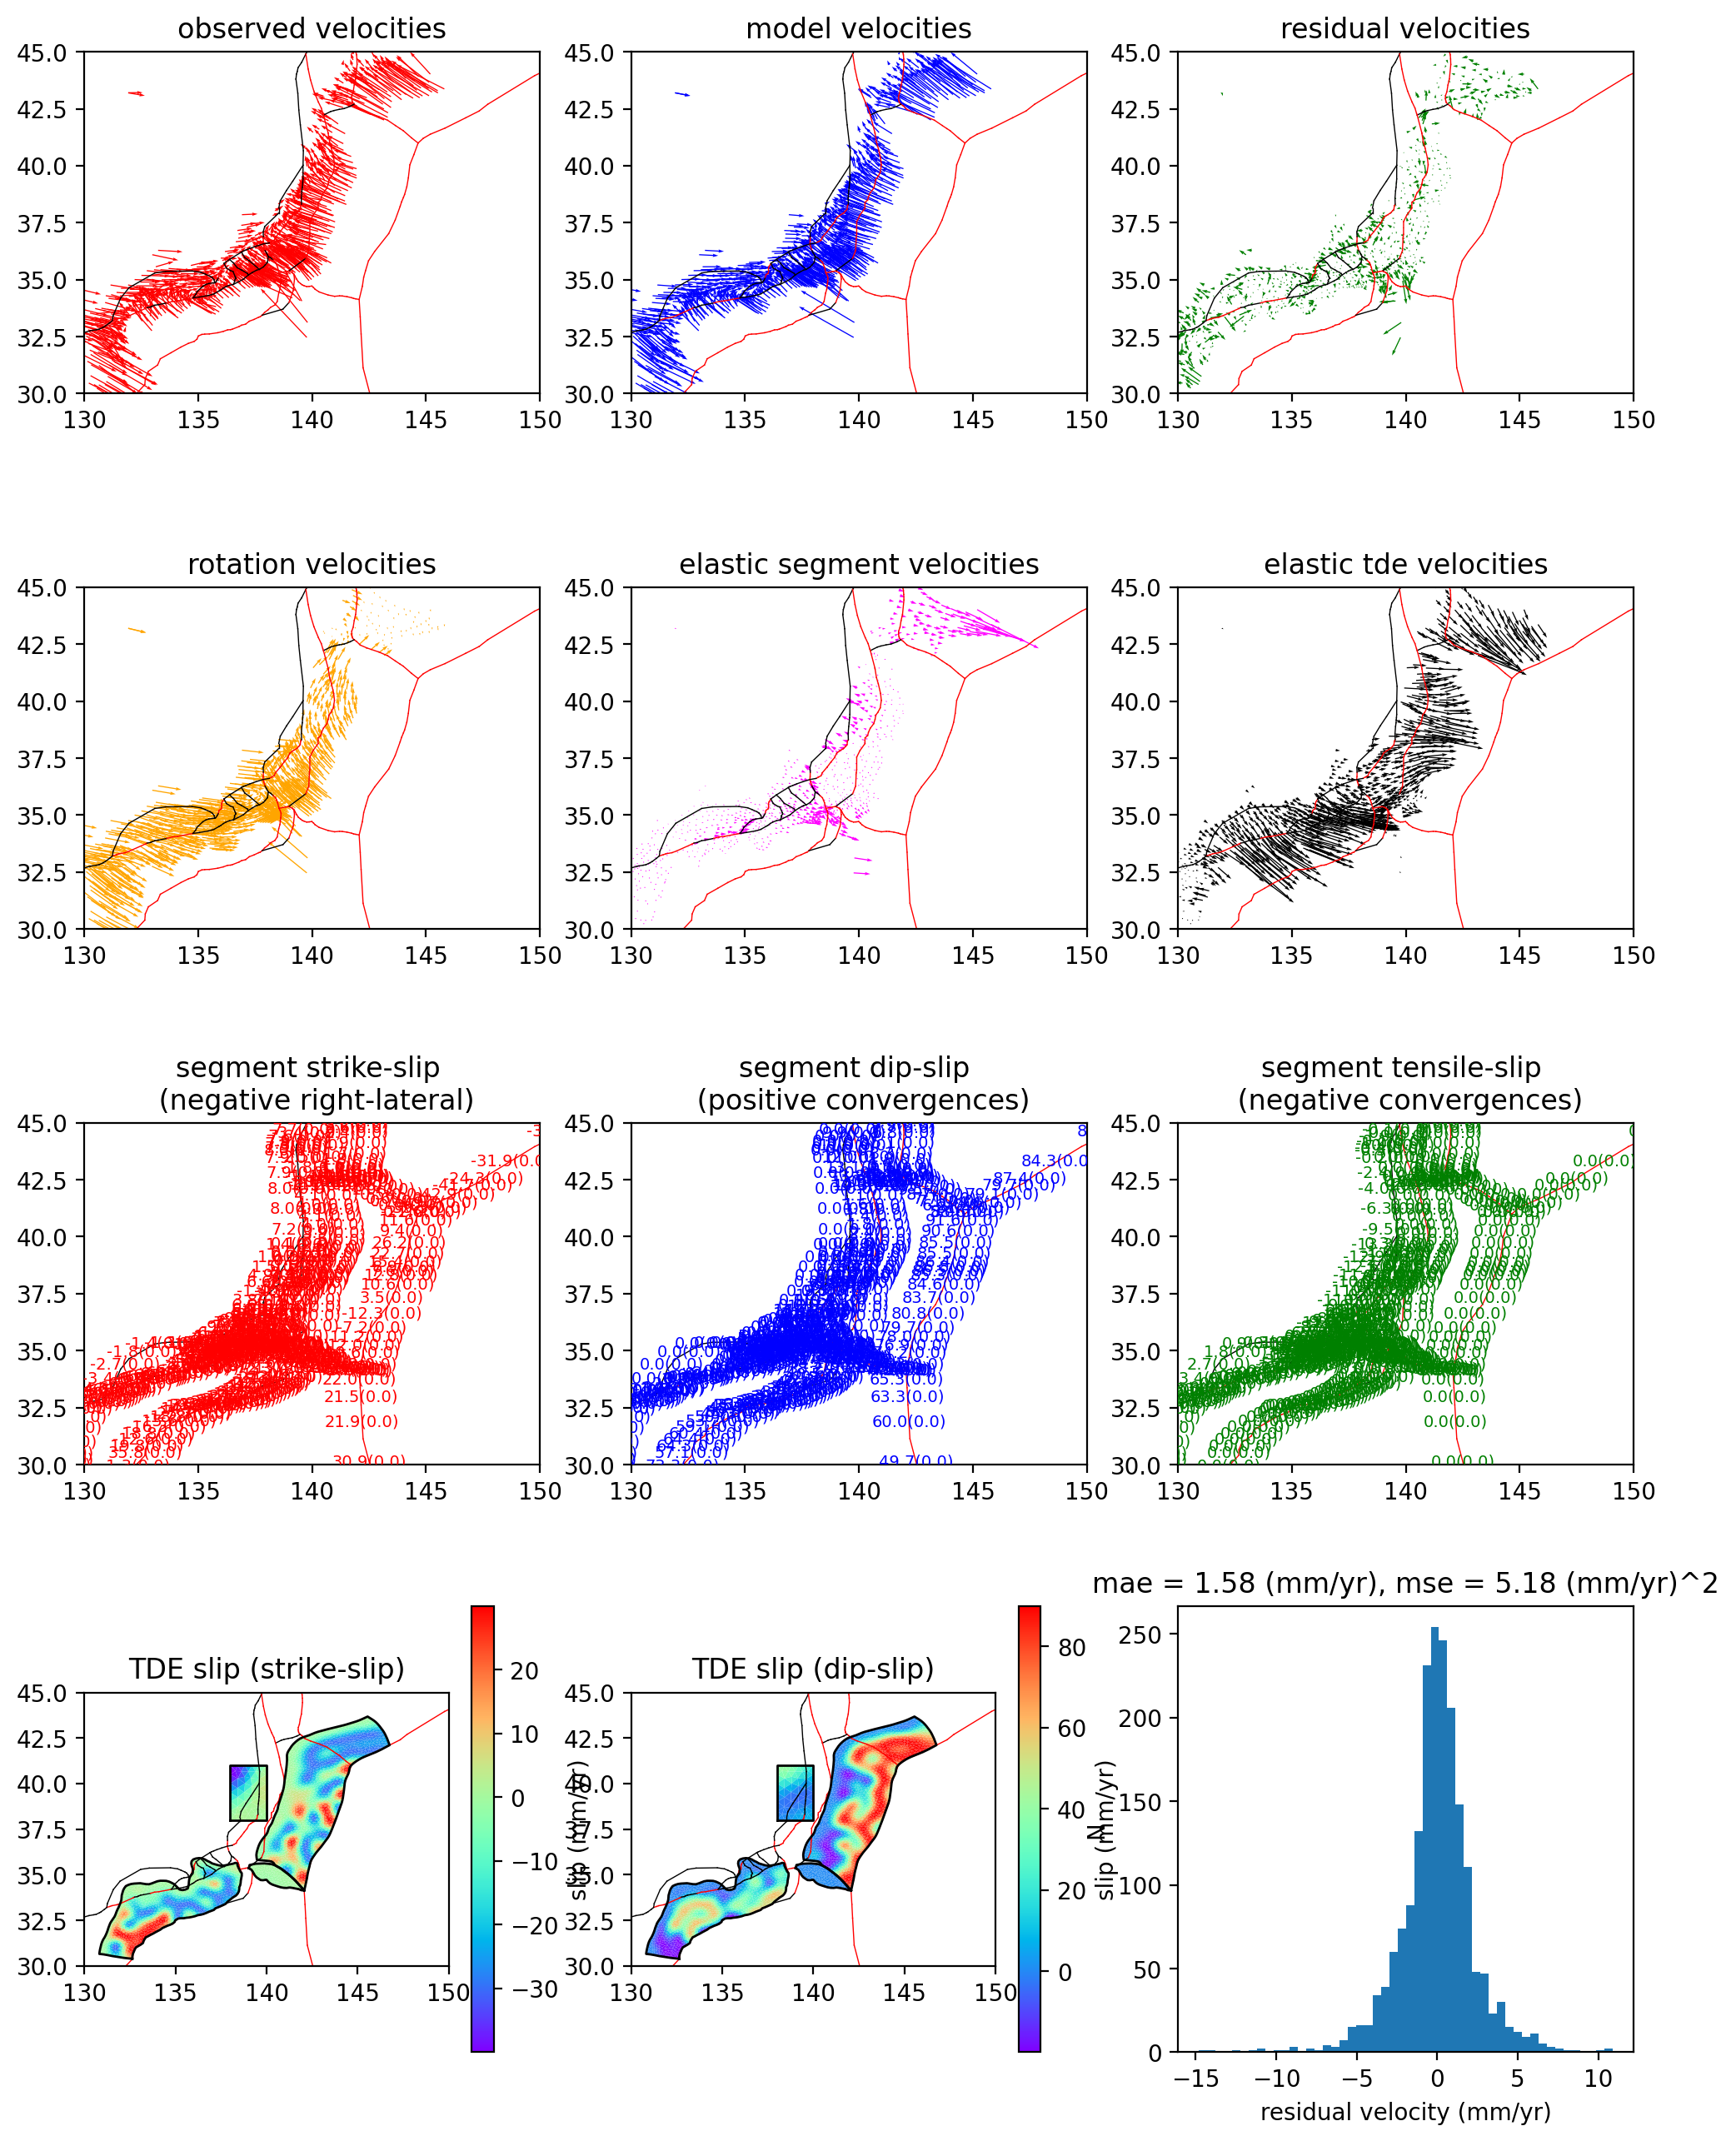

2024-10-30 16:04:39.062 | SUCCESS  | celeri.celeri:plot_estimation_summary:6631 - Wrote figures../runs/0000000418/plot_estimation_summary.(pdf, png)


<Figure size 640x480 with 0 Axes>

In [7]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

In [9]:
# def get_qp_tde_inequality_operator_and_data_vector(index, meshes, operators):
qp_constraint_matrix = np.zeros((4 * index.n_tde_total, index.n_operator_cols_eigen))
qp_constraint_data_vector = np.zeros(4 * index.n_tde_total)

for i in range(index.n_meshes):
    if meshes[i].qp_mesh_tde_bound == 1:
        logger.info(f"USING TDE SLIP RATE BOUNDS FOR MESH {i}")

        # TDE strike- and dip-slip rate lower bounds
        lower_bound_current_mesh = celeri.interleave2(
            meshes[i].qp_mesh_tde_slip_rate_lower_bound_ss * np.ones(index.n_tde[i]),
            meshes[i].qp_mesh_tde_slip_rate_lower_bound_ds * np.ones(index.n_tde[i]),
        )

        # TDE strike- and dip-slip rate upper bounds
        upper_bound_current_mesh = celeri.interleave2(
            meshes[i].qp_mesh_tde_slip_rate_upper_bound_ss * np.ones(index.n_tde[i]),
            meshes[i].qp_mesh_tde_slip_rate_upper_bound_ds * np.ones(index.n_tde[i]),
        )

        # Insert TDE lower bounds into QP constraint data vector (note negative sign)
        qp_constraint_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i]
        ] = -lower_bound_current_mesh

        # Insert TDE upper bounds into QP constraint data vector
        qp_constraint_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i] : index.qp_constraint_tde_rate_end_row_eigen[i]
        ] = upper_bound_current_mesh

        # Insert eigenmode to TDE slip operator into QP constraint data vector for lower bounds (note negative sign)
        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = -operators.eigenvectors_to_tde_slip[i]

        # Insert eigenmode to TDE slip operator into QP constraint data vector for lower bounds
        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i] : index.qp_constraint_tde_rate_end_row_eigen[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = operators.eigenvectors_to_tde_slip[i]

    elif meshes[i].qp_mesh_tde_bound_coupling == 1:
        logger.info(f"USING TDE COUPLING BOUNDS FOR MESH {i}")
        # TDE coupling constraints go here
        # TDE strike- and dip-slip coupling lower bounds
        lower_bound_current_mesh = celeri.interleave2(
            meshes[i].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
            * np.ones(index.n_tde[i]),
            meshes[i].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
            * np.ones(index.n_tde[i]),
        )

        # TDE strike- and dip-slip coupling upper bounds
        upper_bound_current_mesh = celeri.interleave2(
            meshes[i].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
            * np.ones(index.n_tde[i]),
            meshes[i].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
            * np.ones(index.n_tde[i]),
        )

        # Insert TDE lower bounds into QP constraint data vector (note negative sign)
        qp_constraint_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i]
        ] = -lower_bound_current_mesh

        # Insert TDE upper bounds into QP constraint data vector
        qp_constraint_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i] : index.qp_constraint_tde_rate_end_row_eigen[i]
        ] = upper_bound_current_mesh

        # Insert eigenmode to TDE slip operator into QP constraint data vector for lower bounds (note negative sign)
        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = -operators.eigenvectors_to_tde_slip[i]

        # Insert eigenmode to TDE slip operator into QP constraint data vector for lower bounds
        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i] : index.qp_constraint_tde_rate_end_row_eigen[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = operators.eigenvectors_to_tde_slip[i]

        # Insert TDE slip rate rotation partials
        # Insert TDE slip rate partials into QP constraint data vector for lower bounds (note negative sign)
        print(f"{operators.eigenvectors_to_tde_slip[i].shape=}")
        print(f"{operators.rotation_to_tri_slip_rate[i].shape=}")

        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i],
            0 : index.start_col_eigen[i],
        ] = -operators.rotation_to_tri_slip_rate[i]

        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i] : index.qp_constraint_tde_rate_end_row_eigen[i],
            0 : index.start_col_eigen[i],
        ] = operators.rotation_to_tri_slip_rate[i]

        to_plot = qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_end_row_eigen[i],
            :,
        ]
        plt.figure()
        plt.imshow(np.log10(np.abs(to_plot)), aspect="auto")
        plt.title(f"{i=}")
        plt.colorbar()
        plt.show()

    # return qp_constraint_matrix, qp_constraint_data_vector

2024-10-30 16:06:51.139 | INFO     | __main__:<module>:7 - USING TDE SLIP RATE BOUNDS FOR MESH 0
2024-10-30 16:06:51.143 | INFO     | __main__:<module>:7 - USING TDE SLIP RATE BOUNDS FOR MESH 1
2024-10-30 16:06:51.146 | INFO     | __main__:<module>:7 - USING TDE SLIP RATE BOUNDS FOR MESH 2
2024-10-30 16:06:51.147 | INFO     | __main__:<module>:7 - USING TDE SLIP RATE BOUNDS FOR MESH 3


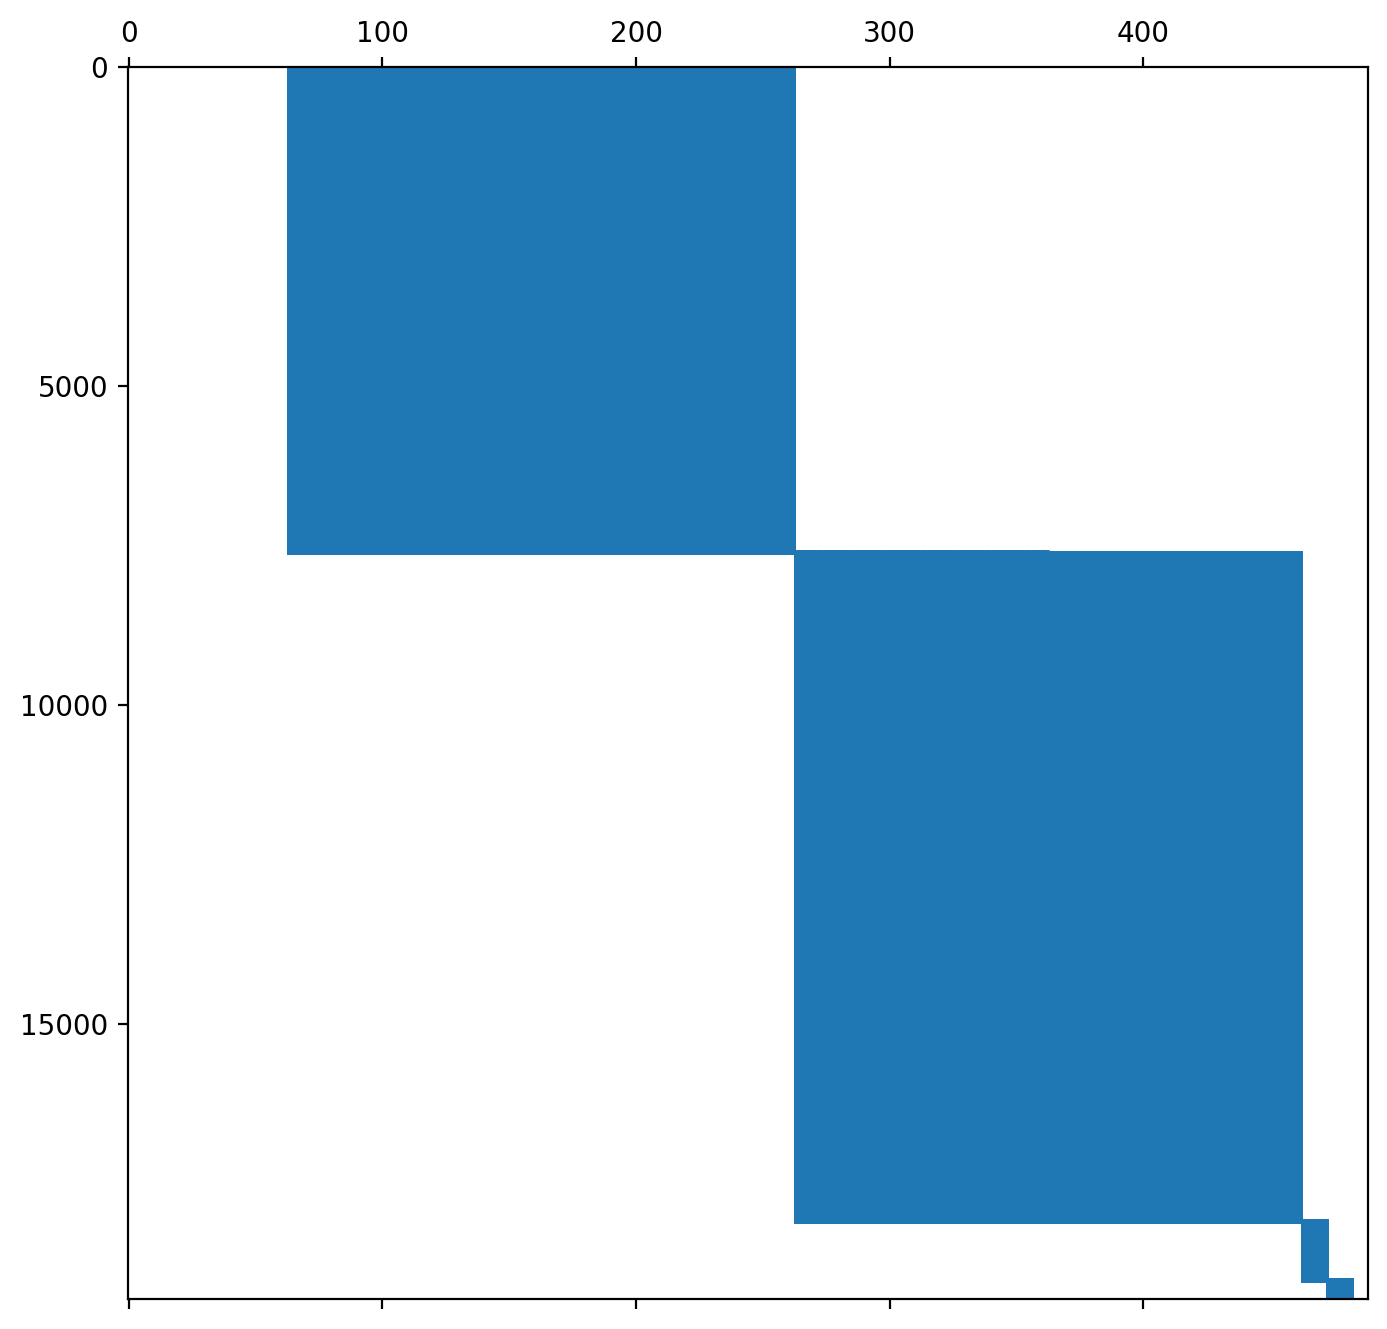

In [10]:
plt.figure(figsize=(8, 8))
plt.spy(qp_constraint_matrix, markersize=1, aspect="auto")
plt.show()

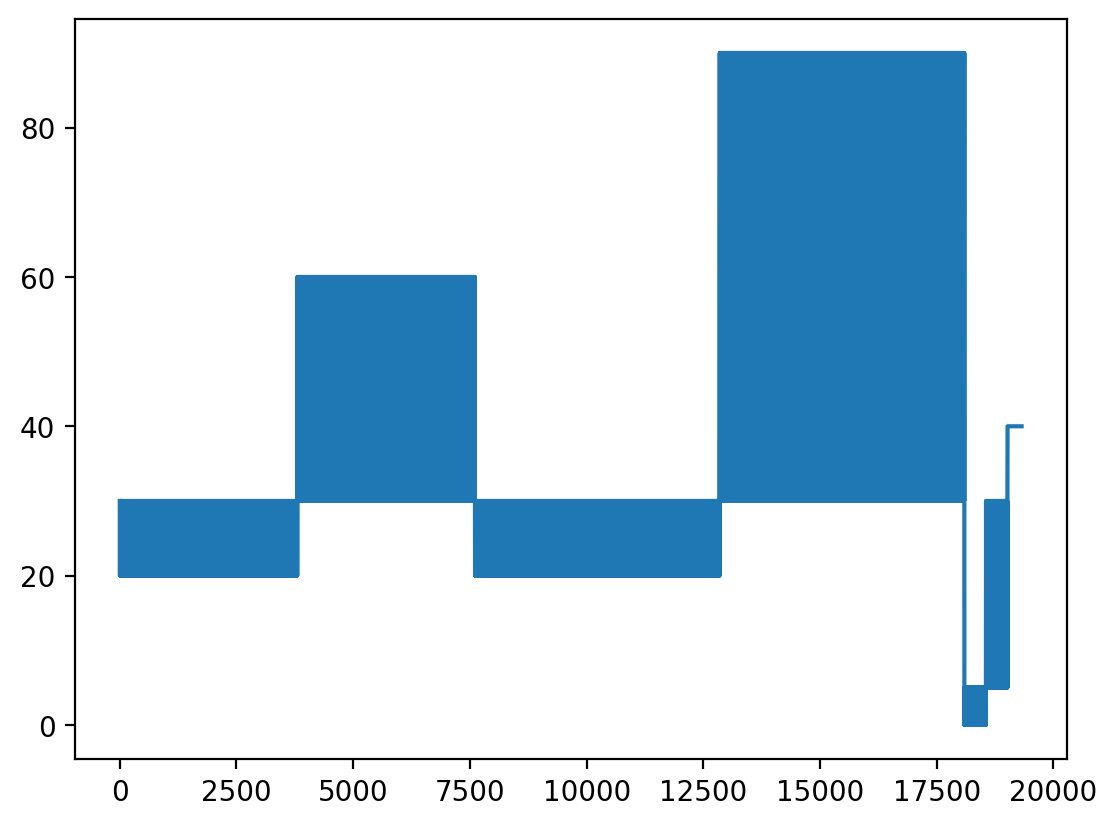

In [11]:
plt.plot(qp_constraint_data_vector)

[]

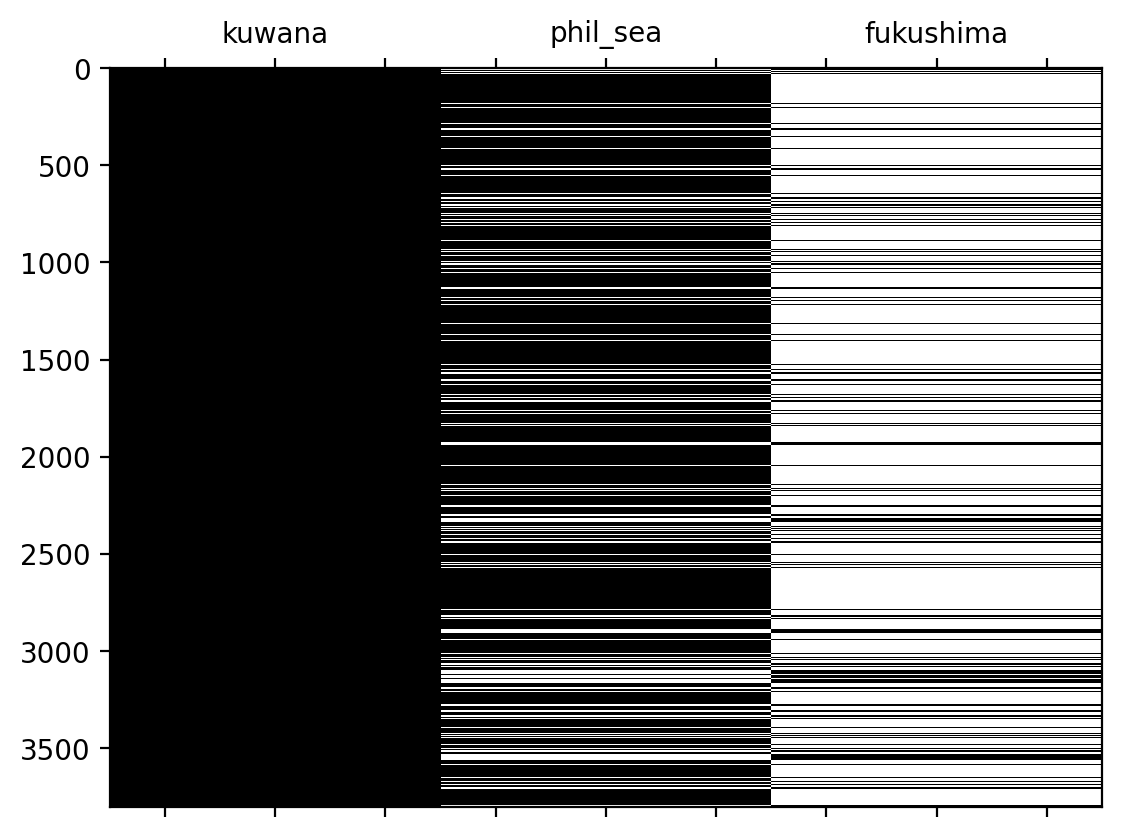

In [12]:
plt.figure()
plt.spy(operators.rotation_to_tri_slip_rate[0][:, 39:48], aspect="auto")
# plt.xticks(range(14))
# plt.xticklabels()

plt.xticks(range(9), ["", "kuwana", "", "", "phil_sea", "", "", "fukushima", ""])
plt.plot()

In [13]:
block

,other1,other2,other3,other4,other5,other6,name,interior_lon,interior_lat,euler_lon,...,rotation_rate,rotation_rate_sig,rotation_flag,apriori_flag,strain_rate,strain_rate_sig,strain_rate_flag,area_steradians,area_plate_carree,block_label
0,0,0,0,0,0,0,kuril-north,141.012,44.169,0,...,0,0,0,0,0,0,0,0.000517,2.153583,0
1,0,0,0,0,0,0,IMP,139.026,36.757,0,...,0,0,0,0,0,0,0,0.001544,7.093937,1
2,0,0,0,0,0,0,name,232.548,74.613,0,...,0,0,0,0,0,0,0,0.000187,0.759888,2
3,0,0,0,0,0,0,pacific,201.774,9.581,0,...,0,0,0,0,0,0,0,0.000259,1.033745,3
4,0,0,0,0,0,0,asia,90.290,57.194,0,...,0,0,0,0,0,0,0,0.618799,5197.088569,4
5,0,0,0,0,0,0,amur,126.871,48.484,0,...,0,0,0,0,0,0,0,0.002323,9.892675,5
6,0,0,0,0,0,0,nw_honshu,17.129,50.806,0,...,0,1,0,0,0,0,0,0.056317,207.861382,6
7,0,0,0,0,0,0,okhotsk,151.258,53.129,0,...,0,0,0,0,0,0,0,0.007581,29.292229,7
8,0,0,0,0,0,0,sanriku,142.136,39.214,0,...,0,0,0,0,0,0,0,0.000105,0.422585,8
9,0,0,0,0,0,0,iida,139.130,38.549,0,...,0,0,0,0,0,0,0,0.006285,26.373494,9


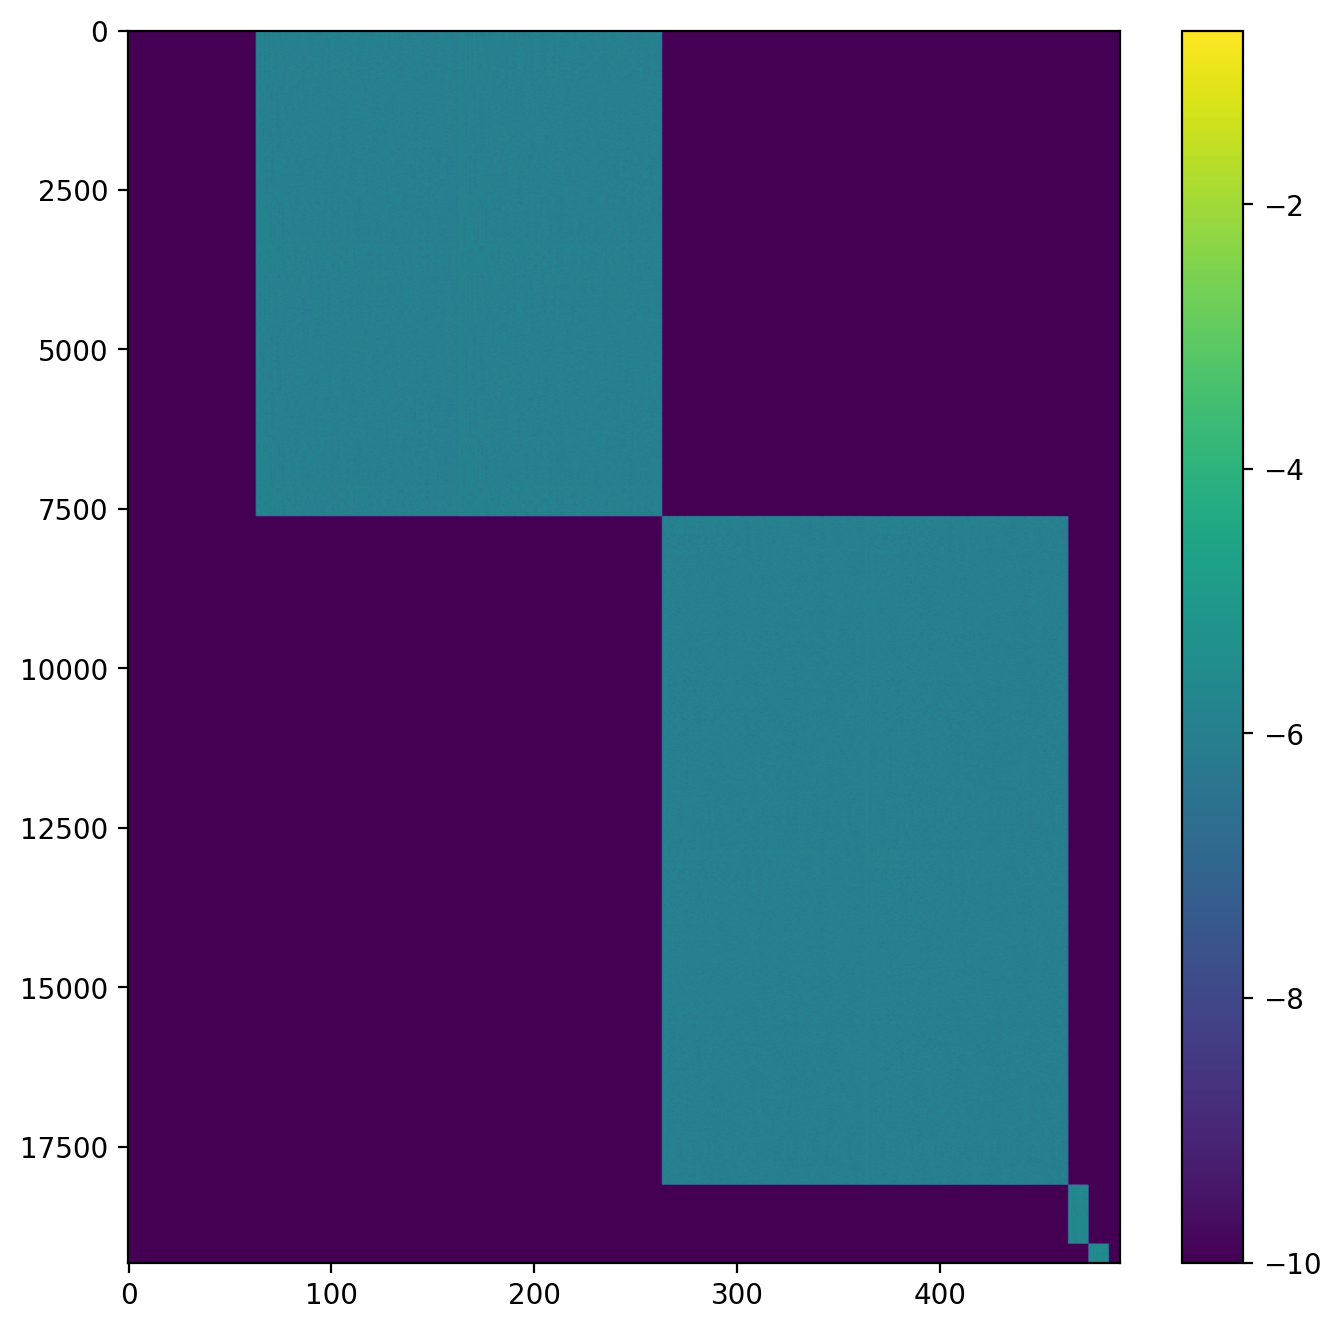

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(np.log10(np.abs(qp_constraint_matrix + 1e-10)), aspect="auto")
plt.colorbar()
plt.show()

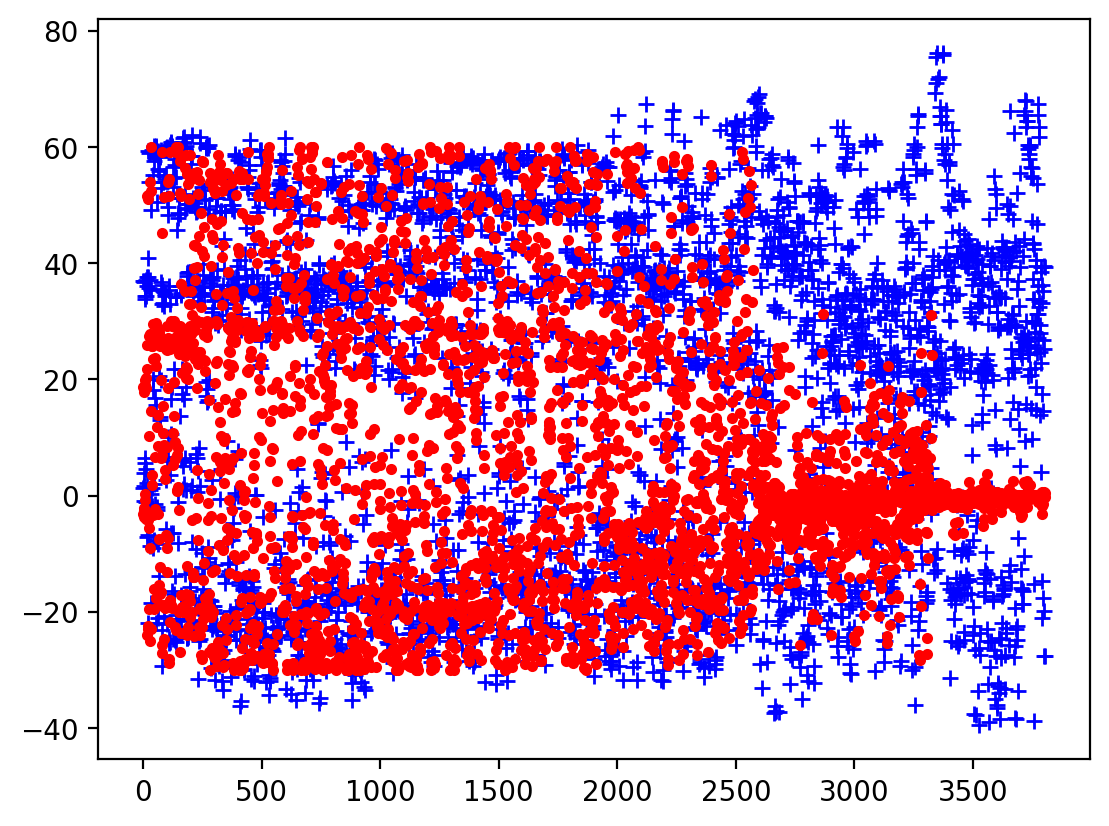

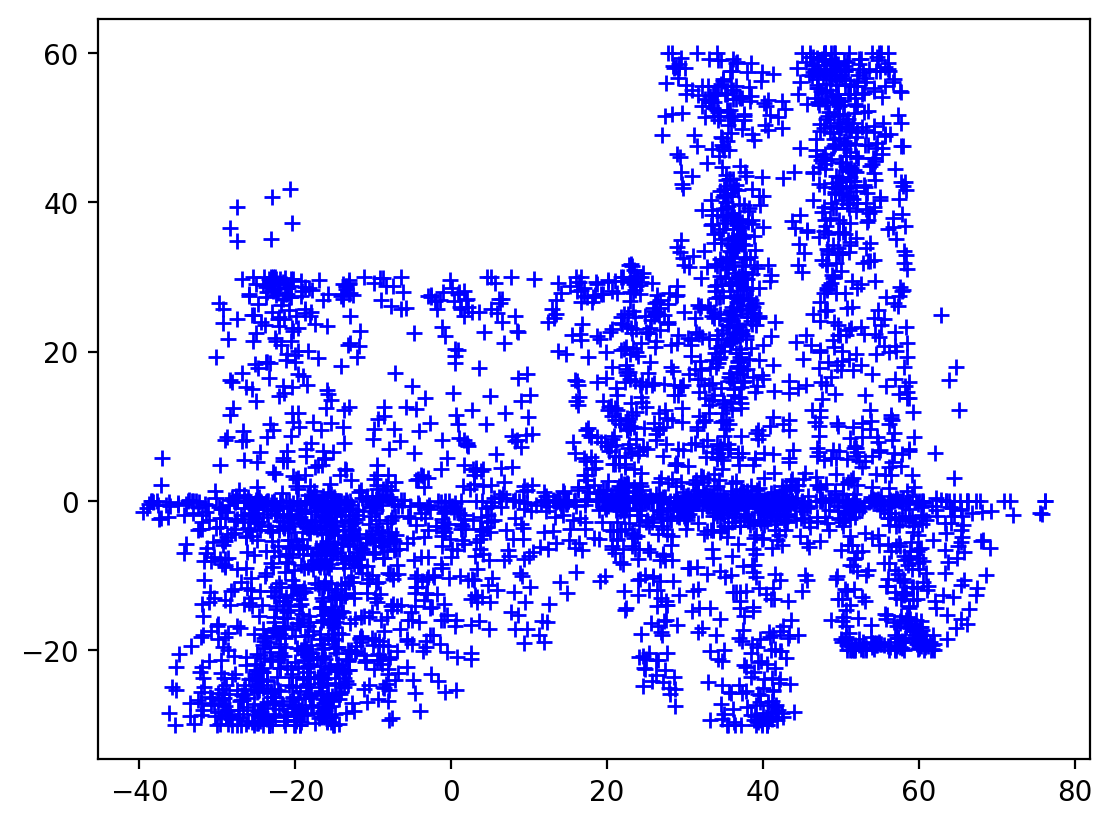

In [ ]:
len(estimation_qp.state_vector)

# Multiply rotation vector components by TDE slip rate partials
jpl = (
    operators.rotation_to_tri_slip_rate[0]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

# Multiply eigen modes by eigen to TDE matrix

bjm = (
    operators.eigenvectors_to_tde_slip[0]
    @ estimation_qp.state_vector[3 * len(block) : 3 * len(block) + 200]
)


plt.figure()
plt.plot(jpl, "+b")
plt.plot(bjm, ".r")
plt.show()

plt.figure()
plt.plot(jpl, bjm, "+b")
plt.show()

In [37]:
print(f"{estimation_qp.state_vector.shape=}")
print(f"{operators.eigenvectors_to_tde_slip[0].shape=}")

estimation_qp.state_vector.shape=(489,)
operators.eigenvectors_to_tde_slip[0].shape=(3804, 200)


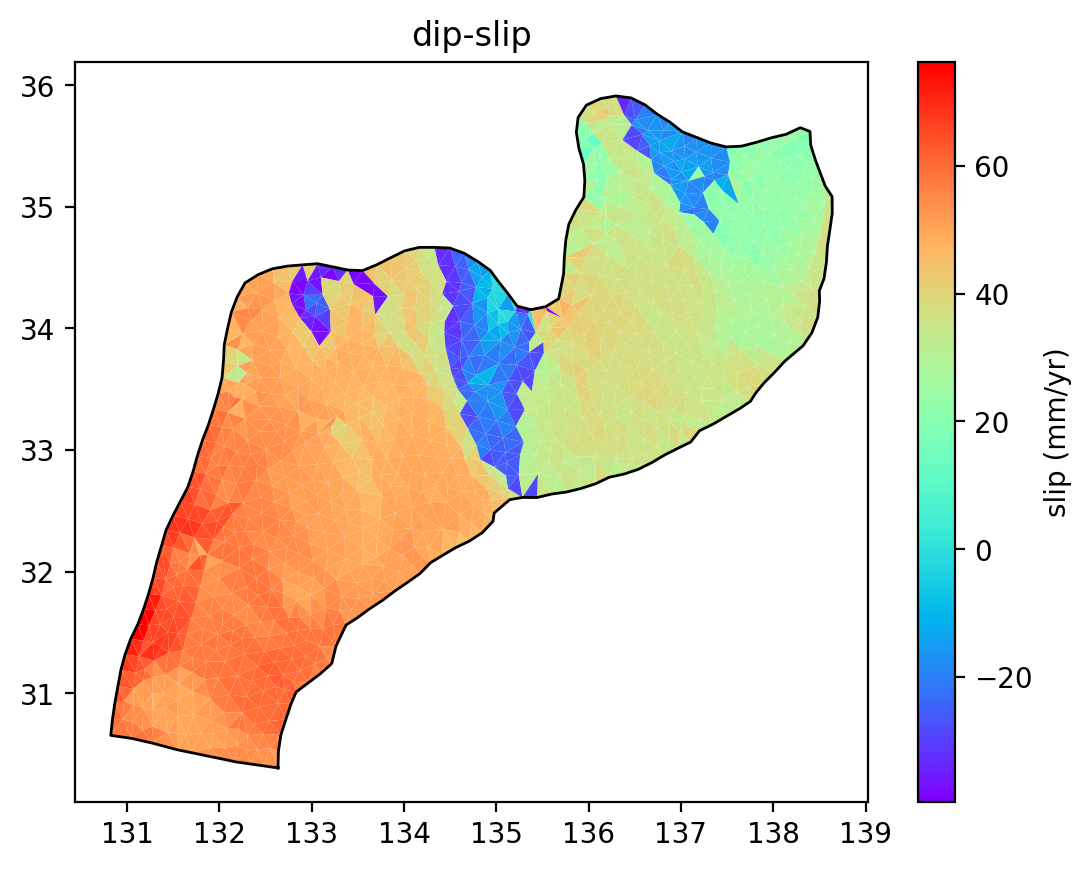

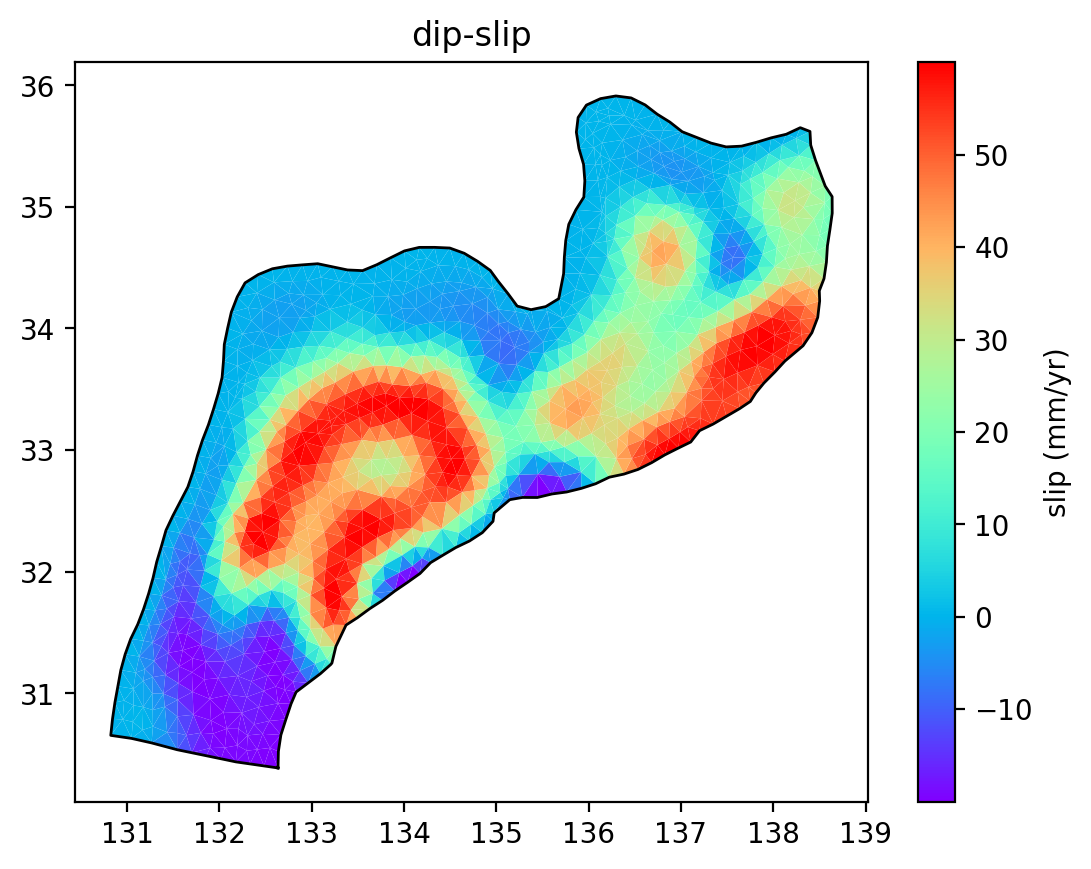

In [ ]:
import matplotlib


def plot_mesh(meshes, fill_value, ax):
    x_coords = meshes.points[:, 0]
    y_coords = meshes.points[:, 1]
    vertex_array = np.asarray(meshes.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(verts, edgecolor="none", cmap="rainbow")
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.colorbar(pc, label="slip (mm/yr)")

    # Add mesh edge
    x_edge = x_coords[meshes.ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes.ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes.ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes.ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=1)


# plt.figure()
# plot_mesh(meshes[0], jpl[0::2], plt.gca())
# plt.title("strike-slip")
# plt.show()

plt.figure()
plot_mesh(meshes[0], jpl[1::2], plt.gca())
plt.title("dip-slip")
plt.show()

# plt.figure()
# plot_mesh(meshes[0], bjm[0::2], plt.gca())
# plt.title("strike-slip")
# plt.show()

plt.figure()
plot_mesh(meshes[0], bjm[1::2], plt.gca())
plt.title("dip-slip")
plt.show()